Импортируем нужные библиотеки

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Пишем функции активации

In [38]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_deactivate(z):
    s = sigmoid(z)
    return s * (1 - s)


def relu(z):
    return np.maximum(0, z)


def relu_deactivate(z):
    return (z > 0).astype(float)


def tanh(z):
    return np.tanh(z)


def tanh_deactivate(z):
    return 1 - np.tanh(z)**2

Создаем класс многослойного персептрона. В нем будет 2 скрытых слоя, скорость обучения - 0.05, коэффициент L2 регуляризации - 0.01

Пишем функции для прямого и обратоного распространений, а также для функции потерь(кросс-энтропия с L2 регуляризацией)

Обновляем параметры с использованием градиентного спуска. lr decay - коэффициент уменьшения скорости обучения - он адаптирует шаги обновления весов модели в процессе обучения. В начале шаги большие, но потом, с каждым шагом они становятся все меньше

In [39]:
class MLP:
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output, learning_rate=0.05, lambd=0.01):
        self.learning_rate = learning_rate
        self.lambd = lambd
        
        self.w1 = np.random.randn(n_input, n_hidden1) * np.sqrt(2 / n_input)
        self.b1 = np.zeros((1, n_hidden1))
        
        self.w2 = np.random.randn(n_hidden1, n_hidden2) * np.sqrt(1 / n_hidden1)
        self.b2 = np.zeros((1, n_hidden2))
        
        self.w3 = np.random.randn(n_hidden2, n_output) * np.sqrt(1 / n_hidden2)
        self.b3 = np.zeros((1, n_output))


    def forward(self, X):
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = relu(self.z1)
        
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = tanh(self.z2)
        
        self.z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = sigmoid(self.z3)
        
        return self.a3
    

    def compute_loss(self, y, output):
        m = y.shape[0]
        loss = - (1/m) * np.sum(y * np.log(output + 1e-8) + (1 - y) * np.log(1 - output + 1e-8))
        L2 = self.lambd / (2*m) * (np.sum(self.w1**2) + np.sum(self.w2**2) + np.sum(self.w3**2))
        
        return loss + L2
    
    
    def backward(self, X, y):
        m = X.shape[0]
        
        dz3 = self.a3 - y
        dw3 = np.dot(self.a2.T, dz3) / m + (self.lambd / m) * self.w3
        db3 = np.sum(dz3, axis=0, keepdims=True) / m
        
        dz2 = np.dot(dz3, self.w3.T)
        dz2 = dz2 * tanh_deactivate(self.z2)
        dw2 = np.dot(self.a1.T, dz2) / m + (self.lambd / m) * self.w2
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        dz1 = np.dot(dz2, self.w2.T)
        dz1 = dz1 * relu_deactivate(self.z1)
        dw1 = np.dot(X.T, dz1) / m + (self.lambd / m) * self.w1
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        grads = {
            'dw3': dw3, 'db3': db3,
            'dw2': dw2, 'db2': db2,
            'dw1': dw1, 'db1': db1
        }
        return grads
    

    def update_parameters(self, grads, lr_decay=0.99):
        self.learning_rate *= lr_decay
        
        self.w1 -= self.learning_rate * grads['dw1']
        self.b1 -= self.learning_rate * grads['db1']
        self.w2 -= self.learning_rate * grads['dw2']
        self.b2 -= self.learning_rate * grads['db2']
        self.w3 -= self.learning_rate * grads['dw3']
        self.b3 -= self.learning_rate * grads['db3']
    

    def train(self, X, y, X_val, y_val, epochs=1000, lr_decay=0.999, patience=100):
        loss_history = []
        val_loss_history = []
        best_val_loss = float('inf')
        no_improve_count = 0
        
        for i in range(epochs):
            # Forward propagation
            output = self.forward(X)
            loss = self.compute_loss(y, output)
            loss_history.append(loss)

            # Back propagation
            grads = self.backward(X, y)
            self.update_parameters(grads, lr_decay)

            # Validation error
            val_output = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_output)
            val_loss_history.append(val_loss)
            
            # Преждевременная остановка
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= patience:
                    print(f'Преждевременная остановка на эпохе {i}')
                    break
            
            if i % 100 == 0:
                print(f'Epoch {i}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
        
        return loss_history, val_loss_history
    

    def predict(self, X, threshold=0.5):
        output = self.forward(X)
        predictions = (output > threshold).astype(int)
        return predictions
    

Теперь генерируем данные: создаем два класса точек

In [40]:
def generate_data(n_samples=200):
    np.random.seed(42)
    X0 = np.random.randn(n_samples // 2, 2) + np.array([-1, -1])
    X1 = np.random.randn(n_samples // 2, 2) + np.array([1, 1])
    X = np.vstack((X0, X1))
    y = np.vstack((np.zeros((n_samples // 2, 1)), np.ones((n_samples // 2, 1))))
    
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

def plot_decision_boundary(mlp, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='bwr', alpha=0.8, edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Граница решения модели')
    plt.show()
X, y = generate_data(200)

Визуализируем данные. С помощью Scaler приводим их к одному масштабу, разбиваем их на тренировочную, тестовую и валидационную выборки

Shape of X: (200, 2)
Shape of y: (200, 1)
Train size: 128, Val size: 32, Test size: 40


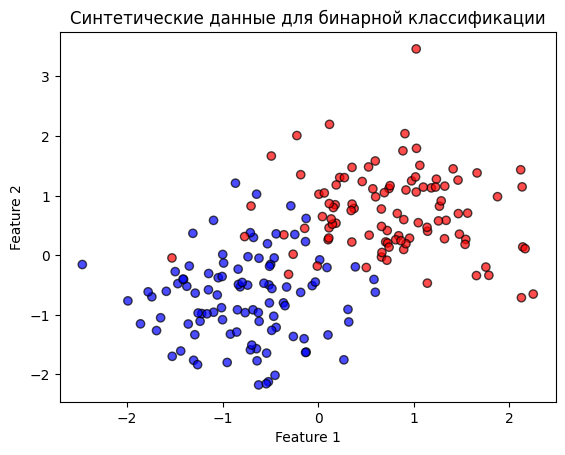

In [41]:

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)
print(f'Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}')

plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='bwr', alpha=0.7, edgecolor='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Синтетические данные для бинарной классификации')
plt.show()

Инициализируем модель и задаем ей параметры архитектуры 

In [42]:
n_input = X.shape[1]
n_hidden1 = 12
n_hidden2 = 8
n_output = 1

mlp = MLP(
    n_input,
    n_hidden1, 
    n_hidden2, 
    n_output, 
    learning_rate=0.05, 
    lambd=0.01
)


Обучаем модель. Максимальное количество эпох сделаем 2000, но у нас критерий преждевременной остановки. Если у нас функция потерь начнет расти, то обучение прервется, потому что дальше она будет только увеличиваться и портить модель

In [43]:
epochs = 1000
loss_history, val_loss_history = mlp.train(
    X_train, y_train, 
    X_val, y_val,
    epochs=epochs,
    lr_decay=0.999,
    patience=100
)

Epoch 0, Loss: 0.5530, Val Loss: 0.5923
Epoch 100, Loss: 0.1920, Val Loss: 0.3439
Epoch 200, Loss: 0.1443, Val Loss: 0.3428
Преждевременная остановка на эпохе 241


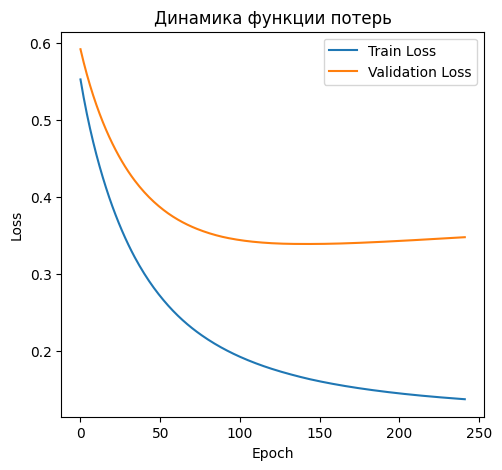

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Динамика функции потерь')
plt.legend()


In [45]:
train_predictions = mlp.predict(X_train)
train_accuracy = np.mean(train_predictions == y_train)

val_predictions = mlp.predict(X_val)
val_accuracy = np.mean(val_predictions == y_val)

test_predictions = mlp.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)

print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

Train accuracy: 0.9531
Validation accuracy: 0.8438
Test accuracy: 0.9250


### ИТОГ

В этом ноутбуке получилось самому написать многослойный персептрон, состоящий из двух скрытых слоев. Были реализованы L2 регуляризация, адапативная скорость обучения и преждевременная остановка, предотвращающая переобучение